# E-commerce Data Analysis with Python and SQL

## Import necessary libraries

The following libraries need to be installed for this notebook to run.

In [1]:
import numpy as np
import pandas as pd
import mysql.connector
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Data Ingestion: CSV to MySQL Database

The code in the following cell automates the process of creating tables, inserting data, and handling data type conversions and NULL values to reduce manual tasks. This will take time to run due to the large amount of data in multiple tables. Once the data has been successfully inserted, you can comment out the code as it is no longer needed. Make necessary changes to the following cell based on your database credentials, folder path etc

In [2]:
# # List of CSV files and their corresponding table names
# csv_files = [
#     ('customers.csv', 'customers'),
#     ('orders.csv', 'orders'),
#     ('sellers.csv', 'sellers'),
#     ('products.csv', 'products'),
#     ('order_items.csv', 'order_items'),
#     ('payments.csv', 'payments'),
#     ('geolocation.csv', 'geolocation')
# ]

# # Connect to the MySQL database
# conn = mysql.connector.connect(
#     host='Host name',
#     user='username',
#     password='your password',
#     database='your target database name'
# )

# cursor = conn.cursor()

# # Folder containing the CSV files
# folder_path = 'C:/Users/bilal/My_workplace/eCommerce-sql-python-project'

# # map pandas data types to SQL data types
# def get_sql_type(dtype):
#     if pd.api.types.is_integer_dtype(dtype):
#         return 'INT'
#     elif pd.api.types.is_float_dtype(dtype):
#         return 'FLOAT'
#     elif pd.api.types.is_bool_dtype(dtype):
#         return 'BOOLEAN'
#     elif pd.api.types.is_datetime64_any_dtype(dtype):
#         return 'DATETIME'
#     else:
#         return 'TEXT'

# for csv_file, table_name in csv_files:
#     file_path = os.path.join(folder_path, csv_file)
    
#     # Read the CSV file into a pandas DataFrame
#     df = pd.read_csv(file_path)
    
#     # Replace NaN with None to handle SQL NULL
#     df = df.where(pd.notnull(df), None)
    
#     # Debugging: Check for NaN values
#     print(f"Processing {csv_file}")
#     print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

#     # Clean column names
#     df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

#     # Generate the CREATE TABLE statement with appropriate data types
#     columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
#     create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
#     cursor.execute(create_table_query)

#     # Insert DataFrame data into the MySQL table
#     for _, row in df.iterrows():
#         # Convert row to tuple and handle NaN/None explicitly
#         values = tuple(None if pd.isna(x) else x for x in row)
#         sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
#         cursor.execute(sql, values)

#     # Commit the transaction for the current CSV file
#     conn.commit()

# # Close the connection
# conn.close()

## Connection to the Database

Make changes based on your database credentials

In [3]:
# Connect to the MySQL database
db_con = mysql.connector.connect(
    host='Host name',
    user='username',
    password='your password',
    database='your target database name'
)

#to activate the cursor
cur = db_con.cursor()

## Analysis with some Basic Queries

### List all unique cities where customers are located.

In [4]:
query = """SELECT distinct customer_city FROM customers; """

cur.execute(query)
#to fetch the data
data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


 ### Count the number of orders placed in 2017.

In [5]:
query = """SELECT count(order_id) FROM ecommerce_data.orders
            WHERE year(orders.order_purchase_timestamp) = 2017 """

cur.execute(query)
#to fetch the data
data = cur.fetchall()

data [0][0]

45101

### Find the total sales per category.

In [6]:
query = """select upper(products.product_category), 
            round(sum(payments.payment_value),2) as total_sales 
            from ecommerce_data.products
            join ecommerce_data.order_items
            	on order_items.product_id = products.product_id
            join ecommerce_data.payments
            	on  payments.order_id = order_items.order_id
            group by product_category; """

cur.execute(query)
#to fetch the data
data = cur.fetchall()

#to show the data entries as a dataframe
df = pd.DataFrame(data, columns = ["Product_category", "Total_Sales"])
df

,Product_category,Total_Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


###  Calculate the percentage of orders that were paid in more than 1 installments.

In [7]:
# payment_installment >1 is used because in our data we have 0 = no installment , 1 = 1 installment
query = """SELECT (SUM(CASE
				WHEN payment_installments > 1 
                THEN 1
                ELSE 0
                END))
                /
                COUNT(payments.order_id)* 100 as installment_orders_percentage
            FROM ecommerce_data.payments; """

cur.execute(query)
#to fetch the data
data = cur.fetchall()
data

[(Decimal('49.4176'),)]

### Count the number of customers from each state. 

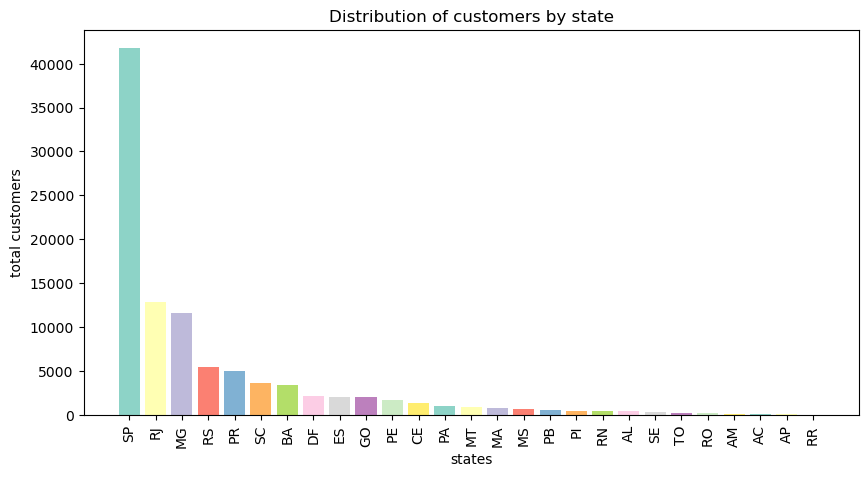

In [8]:
query = """SELECT customers.customer_state, count(customer_id) 
            FROM ecommerce_data.customers
            GROUP BY customer_state; """

cur.execute(query)
#to fetch the data
data = cur.fetchall()

#creating a dataframe from the output
df = pd.DataFrame(data, columns = ["state", "total customers"])
df = df.sort_values(by="total customers", ascending=False)

plt.figure(figsize=(10, 5))
colors = sns.color_palette('Set3', len(data))
plt.bar(df["state"], df["total customers"], color=colors)
plt.xlabel('states')
plt.ylabel('total customers')
plt.title('Distribution of customers by state')
plt.xticks(rotation=90)
plt.show()

###  Calculate the number of orders per month in 2018.

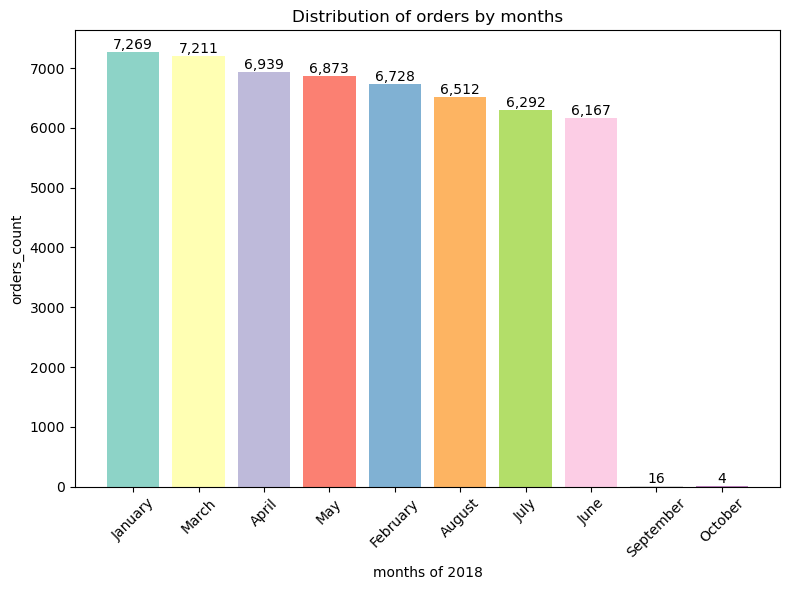

In [9]:
query = """SELECT (monthname(order_purchase_timestamp)) as months, count(order_id) as orders_count
            FROM ecommerce_data.orders
            WHERE year(order_purchase_timestamp) = 2018
            GROUP BY months;"""

cur.execute(query)
#to fetch the data
data = cur.fetchall()

#creating a dataframe from the output
df = pd.DataFrame(data, columns = ["months", "orders_count"])
df = df.sort_values(by="orders_count", ascending=False)

plt.figure(figsize=(8, 6))
colors = sns.color_palette('Set3', len(data))
bars = plt.bar(df["months"], df["orders_count"], color=colors)
plt.xlabel('months of 2018')
plt.ylabel('orders_count')
plt.title('Distribution of orders by months')
plt.xticks(rotation=45)

# Add labels to each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Find the average number of products per order, grouped by customer city.

In [10]:
query = """with count_per_order as
            (SELECT orders.order_id, orders.customer_id, count(order_items.order_id) as ord_count
            FROM ecommerce_data.orders
            JOIN ecommerce_data.order_items
                 ON orders.order_id = order_items.order_id
            GROUP BY orders.order_id, orders.customer_id)

        SELECT customers.customer_city, round(avg(count_per_order.ord_count), 2) as Avg_prod_per_order
        FROM ecommerce_data.customers
        JOIN count_per_order
            ON customers.customer_id = count_per_order.customer_id
        GROUP BY customers.customer_city;"""

cur.execute(query)
#to fetch the data
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer_city", "Avg_prod_per_order"])
df

,customer_city,Avg_prod_per_order
0,sao jose dos campos,1.14
1,indaial,1.12
2,treze tilias,1.27
3,sao paulo,1.16
4,rio de janeiro,1.15
...,...,...
4105,buriti,3.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


### Calculate the percentage of total revenue contributed by each product category.

In [11]:
query = """select upper(products.product_category), 
            round(sum(payments.payment_value) / (select sum(payment_value) from ecommerce_data.payments) * 100, 2) as percent_revenue 
            from ecommerce_data.products
            join ecommerce_data.order_items
            	on order_items.product_id = products.product_id
            join ecommerce_data.payments
            	on  payments.order_id = order_items.order_id
            group by product_category
            order by percent_revenue desc; """

cur.execute(query)
#to fetch the data
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Product Category", "Percent_Revenue"])
df.head()

,Product Category,Percent_Revenue
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


### Identify the correlation between product price and the number of times a product has been purchased.

In [12]:
query = """   select products.product_category, 
		count(order_items.order_id) as order_count,
		round(avg(order_items.price), 2) as avg_price
   from ecommerce_data.products
   join ecommerce_data.order_items
   on products.product_id = order_items.product_id
   group by products.product_category;"""

cur.execute(query)
#to fetch the data
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Product Category", "order_count", "avg_price"])

#finding a correlation between the order count of a product and price
array_order_count = df["order_count"]
array_price = df["avg_price"]

corr = np.corrcoef([array_order_count, array_price])
print(" The correlation between product price and the number of times a product has been purchased is ", corr[0][1])

 The correlation between product price and the number of times a product has been purchased is  -0.10631514167157562


### Calculate the total revenue generated by each seller, and rank them by revenue.

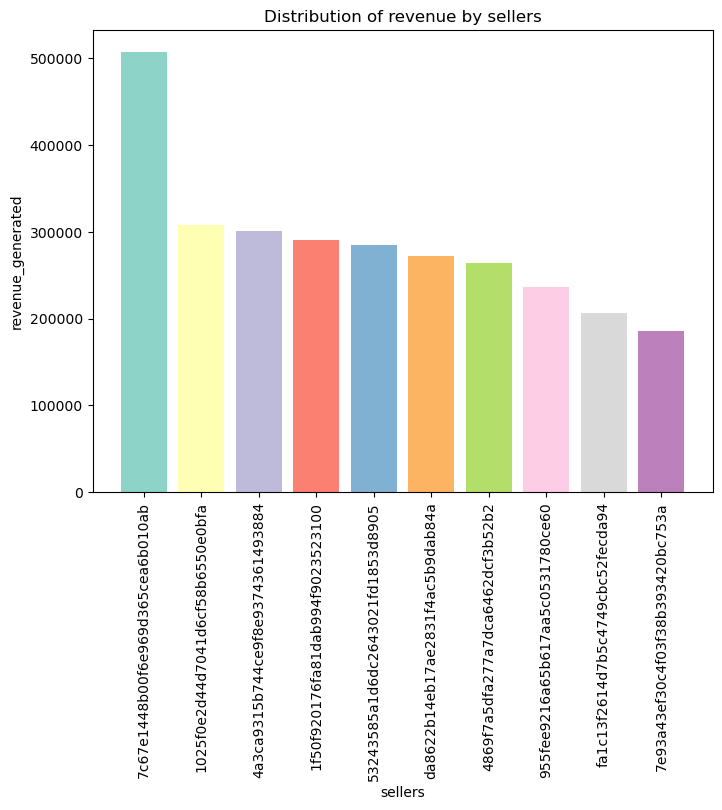

In [13]:
query = """ with revenue_by_seller as (
 select order_items.seller_id, 
		round(sum(payments.payment_value), 2) as revenue,
        rank() over (order by round(sum(payments.payment_value), 2) desc) as rank_rev
from ecommerce_data.order_items
join ecommerce_data.payments
	on  order_items.order_id = payments.order_id 
group by order_items.seller_id)

Select seller_id, revenue, rank_rev
from revenue_by_seller
group by seller_id;"""

cur.execute(query)
#to fetch the data
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["seller_id", "revenue_generated", "Rank"])
#only show 10 highest contributing sellers
df = df.head(10)

plt.figure(figsize=(8, 6))
colors = sns.color_palette('Set3', len(data))
bars = plt.bar(df["seller_id"], df["revenue_generated"], color=colors)
plt.xlabel('sellers')
plt.ylabel('revenue_generated')
plt.title('Distribution of revenue by sellers')
plt.xticks(rotation=90)

# Modify x-axis labels to show only starting letters
# shortened_labels = [seller_id[:10] + '...' for seller_id in df["seller_id"]]
# plt.xticks(range(len(df["seller_id"])), shortened_labels, rotation=90)
# plt.tight_layout()

plt.show()

### Calculate the cumulative sales per month for each year.

In [14]:
query = """select years, 
		months, 
        sales, 
		round(sum(sales) over (order by years, months),2) as cummulative_sales
from (select  year(orders.order_purchase_timestamp) as years,
		month(order_purchase_timestamp) as months,
        round(sum(payments.payment_value),2) as sales
 from ecommerce_data.orders
 join ecommerce_data.payments
 on orders.order_id = payments.order_id
 group by years, months
 order by years, months) as non_commulative_sales;"""

cur.execute(query)
#to fetch the data
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Year", "Month", "Sales", "Cummulative_sales"])
df

,Year,Month,Sales,Cummulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


### Calculate the year-over-year growth rate of total sales.

In [15]:
query = """
with yearly_sales as 
 (select  year(orders.order_purchase_timestamp) as years,
        round(sum(payments.payment_value),2) as sales
 from ecommerce_data.orders
 join ecommerce_data.payments
 on orders.order_id = payments.order_id
 group by years
 order by years)
 
 select years,
		sales,
        -- creating third column to get previous year sales
        lag(sales, 1) over (order by years) as previous_year_sales, 
        -- YOY growth formula = (current sales - previous sales ) / previous sales
		round(((sales - lag(sales, 1) over (order by years)) / lag(sales, 1) over (order by years))*100 ,2) as YOY_growth_percent
from yearly_sales;"""

cur.execute(query)
#to fetch the data
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Year", "Sales", "previous_year_sales", "YOY_percent_growth"])
df

,Year,Sales,previous_year_sales,YOY_percent_growth
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.7
2,2018,8699763.05,7249746.73,20.0
